The goal of this notebook is to test whether the "top snps" from 'New_Locus_Specific_GWAS.ipynb' are ancestry-associated.

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Load in the top snp data
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
top.snp = read.table("top.snp.fdr.txt", sep = "\t", header = T)
head(top.snp)

,gene,snp,fdr
,<chr>,<chr>,<dbl>
1,TUT1,chr11:62578659:C:T,7.962065e-39
2,ECD,chr10:73094386:A:G,7.230154e-36
3,MRTO4,chr1:19252818:GT:G,1.689572e-34
4,RPS5,chr19:58365001:A:G,4.034371e-31
5,RESP18,chr2:219320135:G:A,3.977248e-28
6,SRP14,chr15:40035497:C:G,1.121033e-27


# Extract the SNPs from the big VCF file

In [3]:
#We need to extract these SNPs from the big vcf file, so let's create a bed file so that we can do that
top.snp.for.extraction = top.snp %>%
select(snp) %>%
data.frame()

#write the bed file into the working directory for this project
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
write.table(top.snp.for.extraction, "top_snp_for_extraction.txt", sep ="\t", col.names = FALSE, row.names = FALSE, quote = FALSE)

In [4]:
#Now extract those SNPs with bcftools
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association
/home/jupyter/Ancestry/software/bcftools/bcftools filter --include 'ID=@top_snp_for_extraction.txt' /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz > extracted.snps
"))

In [5]:
#Extract the sample names
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz > sample.names
"))

In [4]:
#Assemble the snp matrix
#Interestingly, there are 96 SNPs that target 98 genes. So I guess there is one SNP that is targeting two overlapping genes? Neat

#First, load in the sample names
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
sample.names = read.table("sample.names", sep = "\t") %>%
pull(1) %>%
c("snp", .)

#load in the filtered SNPS
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
filtered.snps = read.table("extracted.snps", sep = "\t") 

#Now assemble the big matrix
assembled.matrix = filtered.snps %>%
select(-1, -2, -3, -4, -5, -6, -7, -8, -9) %>%
apply(2, function(x){gsub(":..*", "", x)}) %>%
apply(2, function(x){gsub("0\\|0", "0", x)}) %>%
apply(2, function(x){gsub("0\\|1", "1", x)}) %>%
apply(2, function(x){gsub("1\\|0", "1", x)}) %>%
apply(2, function(x){gsub("1\\|1", "2", x)}) %>%
data.frame() %>%
mutate("snp" = filtered.snps$V3, .before = 1) %>%
rename_all(funs( c(sample.names) ))

#Inspect the output
head(assembled.matrix)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


,snp,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:914838:T:A,0,1,0,0,2,2,2,0,2,⋯,2,1,1,0,1,1,1,1,2,1
2,chr1:2166675:GC:G,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,1
3,chr1:2763943:AG:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,chr1:3790892:G:GC,2,2,2,2,0,2,0,2,1,⋯,2,0,0,2,2,2,1,2,2,1
5,chr1:7630154:T:C,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,chr1:14141375:C:G,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Load in the ancestry data

In [3]:
#Load in the ancestry data and format it correctly.
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.calls = read.table("collapsed.ancestry.information.txt", sep = "\t") %>%
mutate(ancestry = ifelse(AFR >= 0.8, "AFR",
                        ifelse(AMR >= 0.8, "AMR",
                              ifelse(EAS >= 0.8, "EAS",
                                    ifelse(EUR >= 0.8, "EUR", 
                                          ifelse(SAS >= 0.8, "SAS", "admixed")))))) %>%
select(sample, ancestry)

#Print the head for the ancestry assignments
head(ancestry.calls)

,sample,ancestry
,<chr>,<chr>
1,ACH-000657,AFR
2,ACH-000617,EUR
3,ACH-000685,AFR
4,ACH-000632,EUR
5,ACH-000171,EUR
6,ACH-000863,EUR


In [5]:
#Get a list of cell lines for each ancestry group
afr.lines = ancestry.calls %>% filter(ancestry %in% "AFR") %>% pull(sample)
amr.lines = ancestry.calls %>% filter(ancestry %in% "AMR") %>% pull(sample)
eas.lines = ancestry.calls %>% filter(ancestry %in% "EAS") %>% pull(sample)
eur.lines = ancestry.calls %>% filter(ancestry %in% "EUR") %>% pull(sample)
sas.lines = ancestry.calls %>% filter(ancestry %in% "SAS") %>% pull(sample)

In [6]:
#calculate the number of cell lines for each group
num.afr = ancestry.calls %>% filter(ancestry %in% "AFR") %>% nrow()
num.non.afr = ancestry.calls %>% nrow(.) -num.afr

num.amr = ancestry.calls %>% filter(ancestry %in% "AMR") %>% nrow()
num.non.amr = ancestry.calls %>% nrow(.) -num.amr

num.eas = ancestry.calls %>% filter(ancestry %in% "EAS") %>% nrow()
num.non.eas = ancestry.calls %>% nrow(.) -num.eas

num.eur = ancestry.calls %>% filter(ancestry %in% "EUR") %>% nrow()
num.non.eur = ancestry.calls %>% nrow(.) -num.eur

num.sas = ancestry.calls %>% filter(ancestry %in% "SAS") %>% nrow()
num.non.sas = ancestry.calls %>% nrow(.) -num.sas

In [7]:
#Calculate the allele count for afr, eas, and eur cell lines
afr.ac = assembled.matrix %>% select(all_of(afr.lines)) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)
non.afr.ac = assembled.matrix %>% select(-all_of(afr.lines)) %>% select(-snp) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)

eas.ac = assembled.matrix %>% select(all_of(eas.lines)) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)
non.eas.ac = assembled.matrix %>% select(-all_of(eas.lines)) %>% select(-snp) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)
 
eur.ac = assembled.matrix %>% select(all_of(eur.lines)) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)
non.eur.ac = assembled.matrix %>% select(-all_of(eur.lines)) %>% select(-snp) %>% apply(1, as.numeric) %>% t() %>% apply(1, sum)

In [8]:
#convert allele count into allele frequency
afr.af = afr.ac/(2*num.afr)
non.afr.af = non.afr.ac/(2*num.non.afr)

eas.af = eas.ac/(2*num.eas)
non.eas.af = non.eas.ac/(2*num.non.eas)

eur.af =  eur.ac/(2*num.eur)
non.eur.af = non.eur.ac/(2*num.non.eur)

In [9]:
#For each SNP plot the median AF in that ancestry group vs the median AF not in that ancestry group
ancestry.vector = c(afr.af, eas.af, eur.af)
non.ancestry.vector = c(non.afr.af, non.eas.af, non.eur.af)
ancestry.assignment = c(rep("AFR", n = length(afr.ac)), rep("EAS", n = length(afr.ac)), rep("EUR", n = length(afr.ac))) 

ancestry.df.for.plotting = cbind(ancestry.vector, non.ancestry.vector, ancestry.assignment) %>%
data.frame() %>% 
rename("ancestry" = 1, "non.ancestry" = 2, "ancestry.assignment" = 3) %>%
mutate(ancestry = as.numeric(ancestry)) %>%
mutate(non.ancestry = as.numeric(non.ancestry))

head(ancestry.df.for.plotting)

,ancestry,non.ancestry,ancestry.assignment
,<dbl>,<dbl>,<chr>
1,0.09756098,0.46852046,AFR
2,0.01219512,0.02046170,EAS
3,0.02439024,0.02938090,EUR
4,0.95121951,0.77649528,AFR
5,0.04878049,0.02098636,EAS
6,0.00000000,0.02833158,EUR


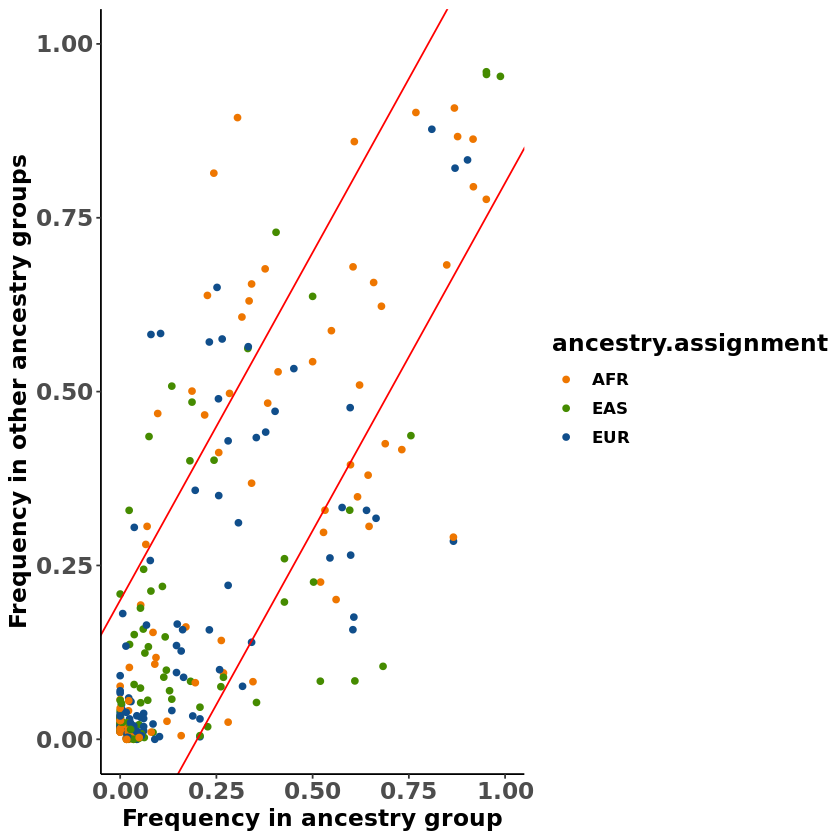

In [10]:
ancestry.df.for.plotting %>%
ggplot() +
geom_point(aes(x = ancestry, y = non.ancestry, color = ancestry.assignment)) +
geom_abline(intercept = -0.2, slope = 1, col = "red") +
geom_abline(intercept = 0.2, slope = 1, col = "red") +
theme_bw() + 

scale_color_manual(values=c("darkorange2", "chartreuse4", "dodgerblue4")) +

ylab("Frequency in other ancestry groups") +
xlab("Frequency in ancestry group") +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold")) +
theme(axis.text.x = element_text(face="bold", size=14), axis.text.y = element_text(face="bold", size=14)) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
) +

xlim(c(0,1)) +
ylim(c(0,1))

#Export it to the google bucket
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
ggsave("ancestry_differential_frequency.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association
gsutil cp ancestry_differential_frequency.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [10]:
#Now let's calculate how many SNPs are ancestry-associated so that we can include this information in the paper
ancestry.analysis.df = cbind(assembled.matrix$snp, afr.af, non.afr.af, eas.af, non.eas.af, eur.af, non.eur.af) %>%
data.frame() %>%
rename("snp" = 1) %>%
inner_join(top.snp, by = "snp") %>%
mutate(afr.af = as.numeric(afr.af)) %>%
mutate(non.afr.af = as.numeric(non.afr.af)) %>%
mutate(eas.af = as.numeric(eas.af)) %>%
mutate(non.eas.af = as.numeric(non.eas.af)) %>%
mutate(eur.af = as.numeric(eur.af)) %>%
mutate(non.eur.af = as.numeric(non.eur.af)) %>%
mutate("afr.differential" = abs(afr.af - non.afr.af)) %>%
mutate("eas.differential" = abs(eas.af - non.eas.af)) %>%
mutate("eur.differential" = abs(eur.af - non.eur.af))

head(ancestry.analysis.df)

#Now calculate how many SNPs are ancestry-associated 
ancestry.analysis.df %>%
filter(afr.differential >= 0.2 | eas.differential >= 0.2 | eur.differential >= 0.2) %>%
nrow()

,snp,afr.af,non.afr.af,eas.af,non.eas.af,eur.af,non.eur.af,gene,fdr,afr.differential,eas.differential,eur.differential
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:914838:T:A,0.09756098,0.46852046,0.3833333,0.483429395,0.532125206,0.329457364,SNAP23,0.7343892,0.370959486,0.10009606,0.20266784
2,chr1:2166675:GC:G,0.01219512,0.02046170,0.0000000,0.028818444,0.029654036,0.005167959,CAAP1,0.2810654,0.008266578,0.02881844,0.02448608
3,chr1:2763943:AG:A,0.02439024,0.02938090,0.0050000,0.039625360,0.035420099,0.019379845,NKAIN4,0.6453377,0.004990659,0.03462536,0.01604025
4,chr1:3790892:G:GC,0.95121951,0.77649528,0.6083333,0.859510086,0.848434926,0.682170543,DCN,0.7695058,0.174724234,0.25117675,0.16626438
5,chr1:7630154:T:C,0.04878049,0.02098636,0.0550000,0.007925072,0.003294893,0.051679587,KLF5,0.0200330,0.027794129,0.04707493,0.04838469
6,chr1:14141375:C:G,0.00000000,0.02833158,0.0900000,0.000000000,0.000000000,0.069767442,STX4,0.1783895,0.028331584,0.09000000,0.06976744


[1] 35

# Make a different type of plot to show the gini for each SNP

[1] "chr1:73819660:G:A"  "chr13:30458378:G:A" "chr4:34013415:A:G" 
[4] "chr11:87580312:T:C" "chr2:139140314:T:C" "chr3:22153105:A:G"

Using snp as id variables



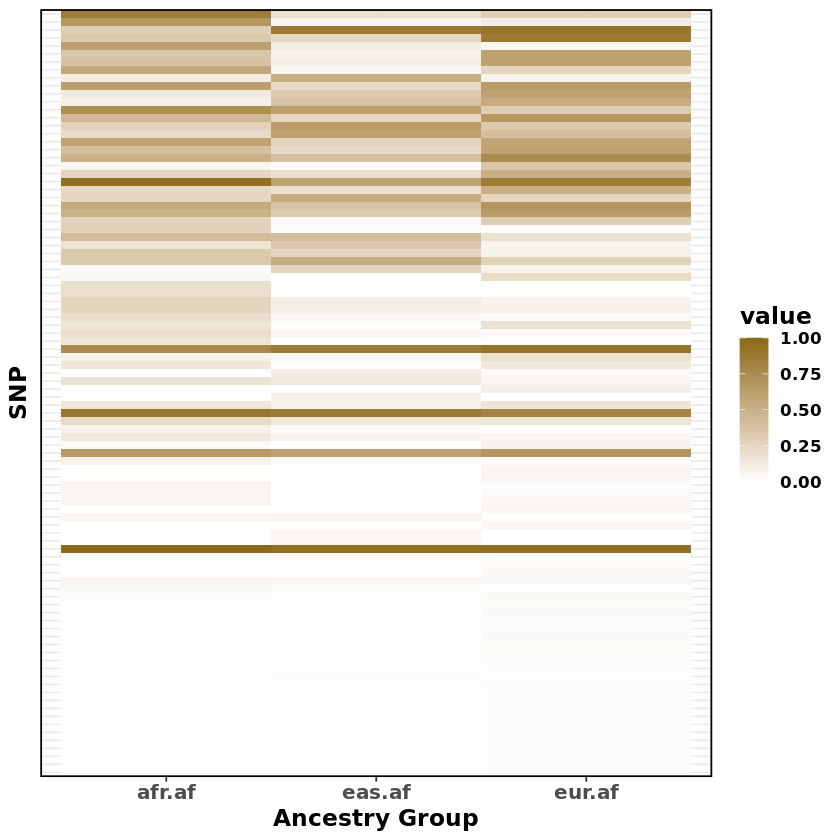

In [48]:
#First calculate the imbalance for each SNP, then add that as a factor to make the heatmap look a bit better 
#Maybe the best way is to just rank by stdev?
factor.order = ancestry.analysis.df %>%
select(afr.af, eas.af, eur.af) %>%
apply(1, sd) %>%
cbind(ancestry.analysis.df$snp, .) %>%
data.frame() %>%
rename("snp" = 1, "sd" = 2) %>%
distinct(snp, sd, .keep_all = TRUE) %>%
arrange(sd, descending = TRUE) %>%
pull(snp)

head(factor.order)


#Plot it as a heatmap
ancestry.analysis.df %>%
select(snp, afr.af, eas.af, eur.af) %>%
mutate(snp = factor(snp, levels = factor.order)) %>%
melt() %>%
ggplot() +
geom_tile(aes(x = variable, y = snp, fill = value)) +

scale_fill_gradient2(low = "white", high = "goldenrod4", 
limit = c(0, 1)) +

theme_bw() +

theme(
panel.border=element_rect(fill = NA, color = "black", size=1)) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.y=element_blank(), 
axis.ticks.y=element_blank() 
) +

ylab("SNP") +
xlab("Ancestry Group")


setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
ggsave("allele_frequency_heatmap.pdf", width = 2, height = 7)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association
gsutil cp allele_frequency_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Make a stacked histogram

Using snp as id variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



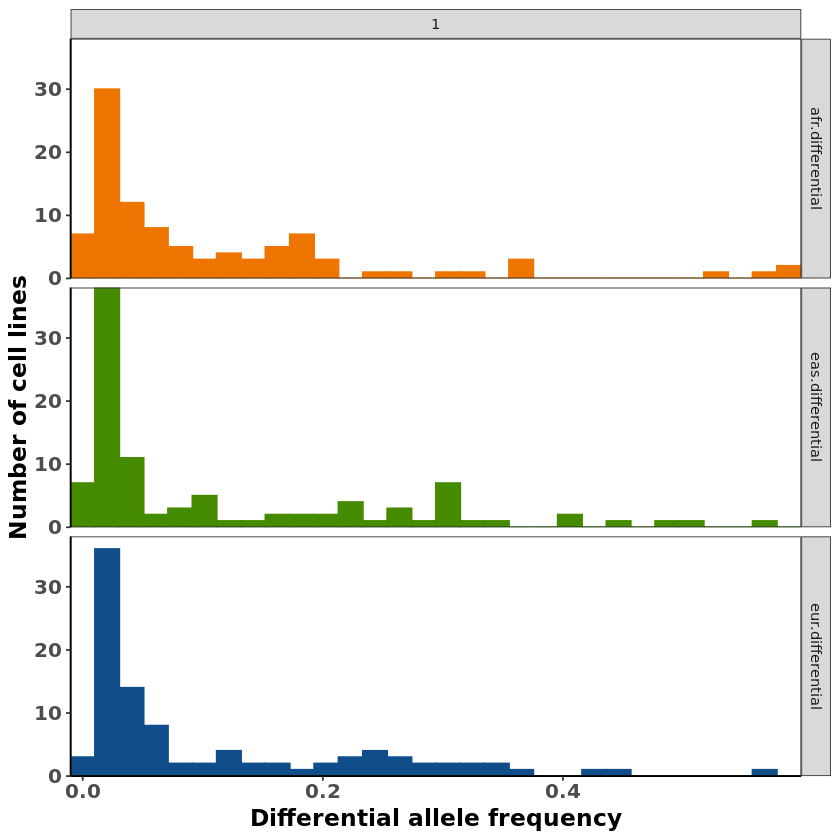

In [63]:
#Assemble a dataframe with all of the ancestry vs all comparisons and plot it
ancestry.analysis.df %>%
select(snp, afr.differential, eas.differential, eur.differential) %>%
melt() %>%
ggplot() +
geom_histogram(aes(x = value, color = variable, fill = variable)) +
facet_grid(variable ~ 1, scales = "free_x") +

scale_fill_manual(values = c("darkorange2", "chartreuse4", "dodgerblue4")) +
scale_color_manual(values = c("darkorange2", "chartreuse4", "dodgerblue4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +


theme(legend.position = "none") + 

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of cell lines") +
xlab("Differential allele frequency")

#Put the exported image into the google bucket
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
ggsave("ccle_allele_frequency_histogram.pdf", width = 2.5, height = 3.5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association
gsutil cp ccle_allele_frequency_histogram.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [66]:
#Calculate the number greater than 0.2 for each ancestry group
afr.differential.snps = ancestry.analysis.df %>% filter(afr.differential > 0.2) %>% nrow()
eas.differential.snps = ancestry.analysis.df %>% filter(eas.differential > 0.2) %>% nrow()
eur.differential.snps = ancestry.analysis.df %>% filter(eur.differential > 0.2) %>% nrow()

afr.differential.snps
eas.differential.snps
eur.differential.snps

[1] 14

[1] 26

[1] 24

In [64]:
ancestry.analysis.df %>% head()

,snp,afr.af,non.afr.af,eas.af,non.eas.af,eur.af,non.eur.af,gene,fdr,afr.differential,eas.differential,eur.differential
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:914838:T:A,0.09756098,0.46852046,0.3833333,0.483429395,0.532125206,0.329457364,SNAP23,0.7343892,0.370959486,0.10009606,0.20266784
2,chr1:2166675:GC:G,0.01219512,0.02046170,0.0000000,0.028818444,0.029654036,0.005167959,CAAP1,0.2810654,0.008266578,0.02881844,0.02448608
3,chr1:2763943:AG:A,0.02439024,0.02938090,0.0050000,0.039625360,0.035420099,0.019379845,NKAIN4,0.6453377,0.004990659,0.03462536,0.01604025
4,chr1:3790892:G:GC,0.95121951,0.77649528,0.6083333,0.859510086,0.848434926,0.682170543,DCN,0.7695058,0.174724234,0.25117675,0.16626438
5,chr1:7630154:T:C,0.04878049,0.02098636,0.0550000,0.007925072,0.003294893,0.051679587,KLF5,0.0200330,0.027794129,0.04707493,0.04838469
6,chr1:14141375:C:G,0.00000000,0.02833158,0.0900000,0.000000000,0.000000000,0.069767442,STX4,0.1783895,0.028331584,0.09000000,0.06976744
